In [1]:
import numpy as np
import pandas as pd
import os
import glob
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.distributions as D
import torch.nn.functional as F
from torch.distributions import constraints
import torch.distributions.transforms as transform

eps = np.finfo(float).eps

plt.rcParams['figure.figsize'] = 10, 10

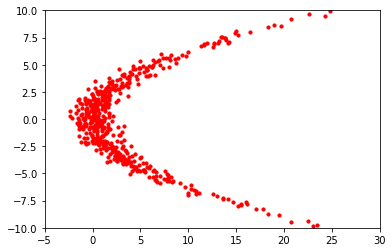

In [2]:
batch_size = 512
# Draw batch_size samples from first distribution
loc2, scale2 = torch.tensor([0.0]), torch.tensor([4.0])
dist2 = D.Normal(loc2, scale2)
x2 = dist2.sample((batch_size,))

# Get a point estimate for all x_2 samples
loc1 = 0.25 * torch.pow(x2, 2)
scale1 = torch.ones_like(loc1)
dist1 = D.Normal(loc1, scale1)
x1 = dist1.sample()

x_samples = torch.stack((x1, x2), dim=0).squeeze(-1).transpose(1, 0)
plt.scatter(x_samples[:, 0], x_samples[:, 1], s=10, color='red')
plt.xlim([-5, 30])
plt.ylim([-10, 10])
plt.show()


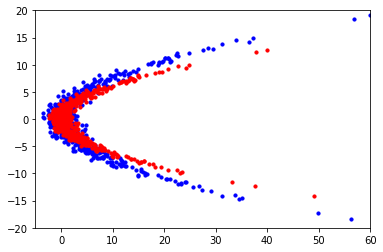

In [3]:
AT = D.transforms.AffineTransform(torch.zeros((1, 2)), torch.tensor(1.5))
y = AT(x_samples)
plt.scatter(y[:, 0], y[:, 1], s=10, color='blue')
plt.scatter(x_samples[:, 0], x_samples[:, 1], s=10, color='red')
plt.xlim([-5, 60])
plt.ylim([-20, 20])
plt.show()


In [4]:
base_dist = D.multivariate_normal.MultivariateNormal(torch.zeros(2), torch.eye(2))

In [5]:
class Flow(transform.Transform, nn.Module):
    
    def __init__(self):
        transform.Transform.__init__(self)
        nn.Module.__init__(self)
            
    # Hacky hash bypass
    def __hash__(self):
        return nn.Module.__hash__(self)

In [ ]:
class ParLeakyRelu(nn.Module):
    def __init__(self, alpha, event_dims=1):
        super(ParLeakyRelu, self).__init__()
        self.alpha = alpha
        self.event_dim = event_dims

    def forward(self, x):
        return torch.where(x >= 0, x, x * self.alpha)

    def inverse(self, x):
        return torch.where(x >= 0, x, 1. / (self.alpha * x))

    def inverse_log_det_jacobian(self, x):
        I = torch.ones_like(x)
        J_inv = torch.where(y >= 0, I, 1.0 / (self.alpha * I))
        # Determine log abs det of J_inv
        log_abs_det_J_inv = torch.log(torch.abs(J_inv))
        return torch.sum(log_abs_det_J_inv, dim=self.event_dim)


In [ ]:
class AffineTransform_bijector(nn.Module):
    """
    Transform via the pointwise affine mapping :math:`y = \text{loc} + \text{scale} \times x`.

    Args:
        loc (Tensor or float): Location parameter.
        scale (Tensor or float): Scale parameter.
        event_dim (int): Optional size of `event_shape`. This should be zero
            for univariate random variables, 1 for distributions over vectors,
            2 for distributions over matrices, etc.
    """
    def __init__(self, loc, scale, event_dim=0):
        super(AffineTransform_bijector, self).__init__()
        self.loc = loc
        self.scale = scale
        self.event_dim = event_dim

    def forward(self, x):
        return self.loc + self.scale * x

    def inverse(self, y):
        return (y - self.loc) / self.scale

    def log_abs_det_jacobian(self, x, y):
        shape = x.shape
        scale = self.scale
        if isinstance(scale, numbers.Number):
            result = x.new_empty(shape).fill_(math.log(abs(scale)))
        else:
            result = torch.abs(scale).log()
        if self.event_dim:
            result_size = result.size()[:-self.event_dim] + (-1,)
            result = result.view(result_size).sum(-1)
            shape = shape[:-self.event_dim]
        return result.expand(shape)

In [ ]:
class MLPBijector(nn.Module):
    def __init__(self, alpha, d, r, num_layers):
        super(MLPBijector, self).__init__()
        self.d = d
        self.r = r
        self.alpha = alpha
        self.num_layers = num_layers
        
        self.num_layers = num_layers
        self.encoder = nn.ModuleList([
            D.transforms.AffineTransform(), 
            ParLeakyRelu(self.alpha)
        ])
        self.output_layer = D.transforms.AffineTransform()
        
    def forward(self, x):
        for i in range(self.num_layers):
            x = encoder(x)
        return self.output_layer(x)

In [ ]:
def loss(x, x_hat,mean):
    nll_loss = nn.NLLLoss(x_hat, x, reduction=mean)
    return nll_loss

def get_optimizer(model):
    lr = 1e-3
    beta1 = 0.9
    beta2 = 0.999
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,
                     betas=(beta1, beta2))
    return optimizer


def init_weights(module):
    for m in module.modules():
        if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
            init.xavier_uniform_(m.weight.data)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias, 0.0)
        elif isinstance(m, nn.Sequential):
            for sub_mod in m:
                init_weights(sub_mod)


alpha = 0.8
d = 2
r = 2
num_layers = 6

model = MLPBijector(alpha, d, r, num_layers)
init_weights(model)
opt = get_optimizer(model)
